## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
%matplotlib inline

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #佔用 GPU 多少比例的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], reg='l1', reg_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    # Regularizers
    if (reg=='l1'):
        regularizers = l1(reg_ratio)
    elif (reg=='l2'):
        regularizers = l2(reg_ratio)
    elif (reg=='l1_l2'):
        regularizers = l1_l2(reg_ratio)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizers)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizers)(x)
        # Batch-normalization    
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
def showPicture(results):
    color_bar = ["r", "g", "b", "y", "m", "k"]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [256, 512]
MOMENTUM = 0.95
REGULARIZATION = {'l1':1e-8, 'l2':1e-8,'l1_l2':1e-8}
Dropout_EXP = [0.25, 0.5, 0.75]

----------------------------------------------------
Experiment with regularizers = (l1,1e-08), dropout = 0.250, batch_size=256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________

Epoch 49/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.1817 - acc: 0.9507 - val_loss: 2.4002 - val_acc: 0.4637
Epoch 50/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.1728 - acc: 0.9533 - val_loss: 2.4635 - val_acc: 0.4725
----------------------------------------------------
Experiment with regularizers = (l1,1e-08), dropout = 0.250, batch_size=512
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__

Epoch 47/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2594 - acc: 0.9381 - val_loss: 2.0037 - val_acc: 0.4873
Epoch 48/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2461 - acc: 0.9440 - val_loss: 2.0143 - val_acc: 0.4897
Epoch 49/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2333 - acc: 0.9478 - val_loss: 2.0531 - val_acc: 0.4820
Epoch 50/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.2204 - acc: 0.9510 - val_loss: 2.0274 - val_acc: 0.4851
----------------------------------------------------
Experiment with regularizers = (l1,1e-08), dropout = 0.500, batch_size=256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1

Epoch 45/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2223 - acc: 0.9366 - val_loss: 2.2745 - val_acc: 0.4802
Epoch 46/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2069 - acc: 0.9425 - val_loss: 2.3147 - val_acc: 0.4867
Epoch 47/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.1953 - acc: 0.9461 - val_loss: 2.4120 - val_acc: 0.4759 - loss: 0.1930 - acc:
Epoch 48/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.1808 - acc: 0.9510 - val_loss: 2.3417 - val_acc: 0.4746
Epoch 49/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.1740 - acc: 0.9541 - val_loss: 2.5094 - val_acc: 0.4618
Epoch 50/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.1622 - acc: 0.9569 - val_loss: 2.4123 - val_acc: 0.4654
----------------------------------------------------
Experiment with regularizers = (l1,1e-08), dropout = 0.500, batch_size=512
______________________

Epoch 43/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3365 - acc: 0.9093 - val_loss: 2.0985 - val_acc: 0.4609
Epoch 44/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3186 - acc: 0.9166 - val_loss: 1.9962 - val_acc: 0.4730
Epoch 45/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.3013 - acc: 0.9245 - val_loss: 1.9544 - val_acc: 0.4818
Epoch 46/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2857 - acc: 0.9276 - val_loss: 1.9669 - val_acc: 0.4833
Epoch 47/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2705 - acc: 0.9343 - val_loss: 1.9986 - val_acc: 0.4753
Epoch 48/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.2533 - acc: 0.9401 - val_loss: 2.0299 - val_acc: 0.4868
Epoch 49/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2432 - acc: 0.9424 - val_loss: 2.0364 - val_acc: 0.4871
Epoch 50/50
50000/50000 [=========

Epoch 41/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.2718 - acc: 0.9201 - val_loss: 2.1383 - val_acc: 0.4743
Epoch 42/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2546 - acc: 0.9259 - val_loss: 2.2925 - val_acc: 0.4514
Epoch 43/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2496 - acc: 0.9260 - val_loss: 2.2729 - val_acc: 0.4679
Epoch 44/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.2347 - acc: 0.9323 - val_loss: 2.3022 - val_acc: 0.4688
Epoch 45/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2176 - acc: 0.9376 - val_loss: 2.2696 - val_acc: 0.4785
Epoch 46/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2135 - acc: 0.9392 - val_loss: 2.4102 - val_acc: 0.4615
Epoch 47/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2015 - acc: 0.9433 - val_loss: 2.4495 - val_acc: 0.4675
Epoch 48/50
50000/50000 [=========

Epoch 39/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3952 - acc: 0.8894 - val_loss: 1.8013 - val_acc: 0.4904
Epoch 40/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3795 - acc: 0.8942 - val_loss: 1.8538 - val_acc: 0.4768
Epoch 41/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.3553 - acc: 0.9036 - val_loss: 1.8191 - val_acc: 0.4849
Epoch 42/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3354 - acc: 0.9117 - val_loss: 1.8279 - val_acc: 0.4902
Epoch 43/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.3161 - acc: 0.9190 - val_loss: 1.9261 - val_acc: 0.4827
Epoch 44/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.3014 - acc: 0.9236 - val_loss: 1.9955 - val_acc: 0.4738
Epoch 45/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2877 - acc: 0.9275 - val_loss: 1.9395 - val_acc: 0.4861
Epoch 46/50
50000/50000 [=========

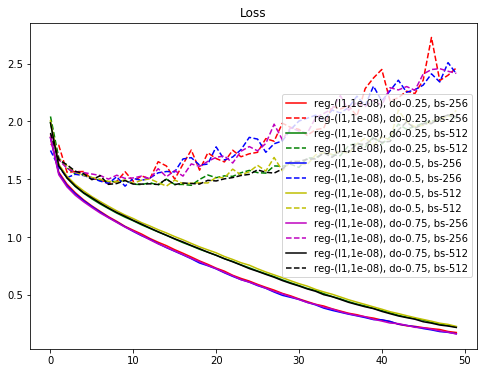

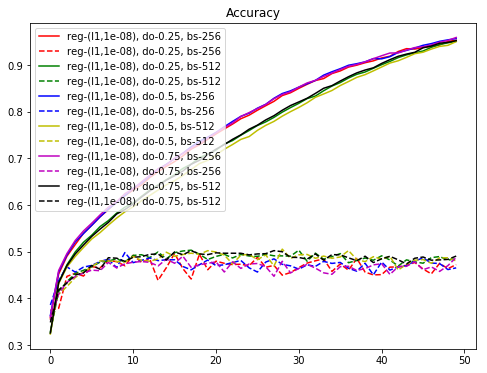

----------------------------------------------------
Experiment with regularizers = (l2,1e-08), dropout = 0.250, batch_size=256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________

Epoch 49/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.1823 - acc: 0.9491 - val_loss: 2.5344 - val_acc: 0.4625
Epoch 50/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.1741 - acc: 0.9522 - val_loss: 2.4602 - val_acc: 0.4730
----------------------------------------------------
Experiment with regularizers = (l2,1e-08), dropout = 0.250, batch_size=512
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__

Epoch 47/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2743 - acc: 0.9307 - val_loss: 2.0394 - val_acc: 0.4728
Epoch 48/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2591 - acc: 0.9370 - val_loss: 2.0974 - val_acc: 0.4717
Epoch 49/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2456 - acc: 0.9421 - val_loss: 2.0323 - val_acc: 0.4762
Epoch 50/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2302 - acc: 0.9470 - val_loss: 2.0633 - val_acc: 0.4737
----------------------------------------------------
Experiment with regularizers = (l2,1e-08), dropout = 0.500, batch_size=256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1

Epoch 45/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2303 - acc: 0.9326 - val_loss: 2.3727 - val_acc: 0.4745
Epoch 46/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2167 - acc: 0.9379 - val_loss: 2.3203 - val_acc: 0.4536
Epoch 47/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2026 - acc: 0.9439 - val_loss: 2.2551 - val_acc: 0.4799
Epoch 48/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.1946 - acc: 0.9450 - val_loss: 2.4707 - val_acc: 0.4666
Epoch 49/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.1857 - acc: 0.9480 - val_loss: 2.3368 - val_acc: 0.4741
Epoch 50/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.1721 - acc: 0.9539 - val_loss: 2.4720 - val_acc: 0.4638
----------------------------------------------------
Experiment with regularizers = (l2,1e-08), dropout = 0.500, batch_size=512
____________________________________________

Epoch 43/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3287 - acc: 0.9113 - val_loss: 1.9073 - val_acc: 0.4838
Epoch 44/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3084 - acc: 0.9196 - val_loss: 1.9511 - val_acc: 0.4825
Epoch 45/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2920 - acc: 0.9258 - val_loss: 1.9487 - val_acc: 0.4947
Epoch 46/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2758 - acc: 0.9324 - val_loss: 1.9630 - val_acc: 0.4852
Epoch 47/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.2658 - acc: 0.9342 - val_loss: 2.0256 - val_acc: 0.4805
Epoch 48/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.2458 - acc: 0.9433 - val_loss: 2.0076 - val_acc: 0.4904
Epoch 49/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.2314 - acc: 0.9476 - val_loss: 2.0687 - val_acc: 0.4775
Epoch 50/50
50000/50000 [=========

Epoch 41/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.2876 - acc: 0.9113 - val_loss: 2.2549 - val_acc: 0.4675
Epoch 42/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2608 - acc: 0.9228 - val_loss: 2.2494 - val_acc: 0.4567
Epoch 43/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.2491 - acc: 0.9268 - val_loss: 2.3106 - val_acc: 0.4684
Epoch 44/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2333 - acc: 0.9323 - val_loss: 2.2513 - val_acc: 0.4757
Epoch 45/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2301 - acc: 0.9321 - val_loss: 2.3021 - val_acc: 0.4676
Epoch 46/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2156 - acc: 0.9374 - val_loss: 2.2929 - val_acc: 0.4693
Epoch 47/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2058 - acc: 0.9411 - val_loss: 2.3050 - val_acc: 0.4753
Epoch 48/50
50000/50000 [=========

Epoch 39/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.4069 - acc: 0.8837 - val_loss: 1.8556 - val_acc: 0.4899
Epoch 40/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3908 - acc: 0.8880 - val_loss: 1.8433 - val_acc: 0.4836
Epoch 41/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3681 - acc: 0.8970 - val_loss: 1.9461 - val_acc: 0.4781
Epoch 42/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3526 - acc: 0.9033 - val_loss: 1.9545 - val_acc: 0.4776
Epoch 43/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3318 - acc: 0.9108 - val_loss: 1.9145 - val_acc: 0.4817
Epoch 44/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3134 - acc: 0.9167 - val_loss: 1.9908 - val_acc: 0.4750
Epoch 45/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2963 - acc: 0.9242 - val_loss: 2.0324 - val_acc: 0.4853
Epoch 46/50
50000/50000 [=========

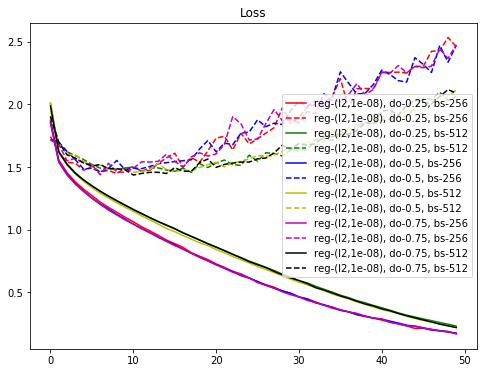

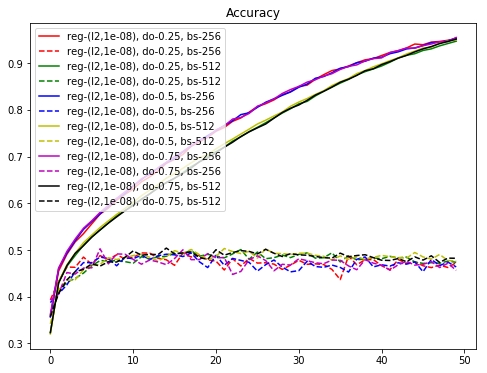

----------------------------------------------------
Experiment with regularizers = (l1_l2,1e-08), dropout = 0.250, batch_size=256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________

Epoch 49/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.1210 - acc: 0.7136 - val_loss: 2.2453 - val_acc: 0.4132
Epoch 50/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.1244 - acc: 0.7118 - val_loss: 2.2906 - val_acc: 0.4143
----------------------------------------------------
Experiment with regularizers = (l1_l2,1e-08), dropout = 0.250, batch_size=512
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    

Epoch 47/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2430 - acc: 0.7935 - val_loss: 2.8337 - val_acc: 0.4264
Epoch 48/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2003 - acc: 0.7995 - val_loss: 2.9395 - val_acc: 0.3964
Epoch 49/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1816 - acc: 0.7989 - val_loss: 3.0590 - val_acc: 0.3848
Epoch 50/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1829 - acc: 0.7901 - val_loss: 3.1154 - val_acc: 0.3655
----------------------------------------------------
Experiment with regularizers = (l1_l2,1e-08), dropout = 0.500, batch_size=256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)             

Epoch 45/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.1396 - acc: 0.7050 - val_loss: 2.2456 - val_acc: 0.4267
Epoch 46/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.1202 - acc: 0.7131 - val_loss: 2.1666 - val_acc: 0.4156
Epoch 47/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.1142 - acc: 0.7138 - val_loss: 2.3444 - val_acc: 0.4145
Epoch 48/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.1141 - acc: 0.7127 - val_loss: 2.2852 - val_acc: 0.4252
Epoch 49/50
50000/50000 [==============================] - 4s 70us/step - loss: 1.1070 - acc: 0.7153 - val_loss: 2.2608 - val_acc: 0.4091
Epoch 50/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.0994 - acc: 0.7174 - val_loss: 2.2553 - val_acc: 0.4260
----------------------------------------------------
Experiment with regularizers = (l1_l2,1e-08), dropout = 0.500, batch_size=512
_________________________________________

Epoch 43/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.3949 - acc: 0.7782 - val_loss: 3.1814 - val_acc: 0.3896
Epoch 44/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.3308 - acc: 0.7913 - val_loss: 2.9647 - val_acc: 0.4220
Epoch 45/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2976 - acc: 0.7917 - val_loss: 2.8905 - val_acc: 0.3957
Epoch 46/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2784 - acc: 0.7852 - val_loss: 2.9426 - val_acc: 0.3875
Epoch 47/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2411 - acc: 0.7926 - val_loss: 3.0424 - val_acc: 0.3907
Epoch 48/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.1887 - acc: 0.8049 - val_loss: 3.6424 - val_acc: 0.3449
Epoch 49/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.1696 - acc: 0.8022 - val_loss: 3.1511 - val_acc: 0.3943
Epoch 50/50
50000/50000 [=========

50000/50000 [==============================] - 3s 70us/step - loss: 1.1628 - acc: 0.6986 - val_loss: 2.0703 - val_acc: 0.4469
Epoch 41/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.1567 - acc: 0.7011 - val_loss: 2.2439 - val_acc: 0.4236
Epoch 42/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.1549 - acc: 0.6978 - val_loss: 2.6025 - val_acc: 0.3831
Epoch 43/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.1455 - acc: 0.7004 - val_loss: 3.0437 - val_acc: 0.3370
Epoch 44/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.1459 - acc: 0.7031 - val_loss: 2.2551 - val_acc: 0.4296
Epoch 45/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.1283 - acc: 0.7080 - val_loss: 2.1697 - val_acc: 0.4313
Epoch 46/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.1455 - acc: 0.7040 - val_loss: 2.1794 - val_acc: 0.4271
Epoch 47/50
50000/50000 [=====================

Epoch 38/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.5972 - acc: 0.7798 - val_loss: 3.1733 - val_acc: 0.4056
Epoch 39/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.5481 - acc: 0.7791 - val_loss: 3.8613 - val_acc: 0.3154
Epoch 40/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.5021 - acc: 0.7787 - val_loss: 3.3708 - val_acc: 0.3703
Epoch 41/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.4734 - acc: 0.7761 - val_loss: 3.3411 - val_acc: 0.3482
Epoch 42/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.4261 - acc: 0.7822 - val_loss: 3.3954 - val_acc: 0.3302
Epoch 43/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.3891 - acc: 0.7812 - val_loss: 2.9755 - val_acc: 0.3820
Epoch 44/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.3851 - acc: 0.7691 - val_loss: 3.3623 - val_acc: 0.3413
Epoch 45/50
50000/50000 [=========

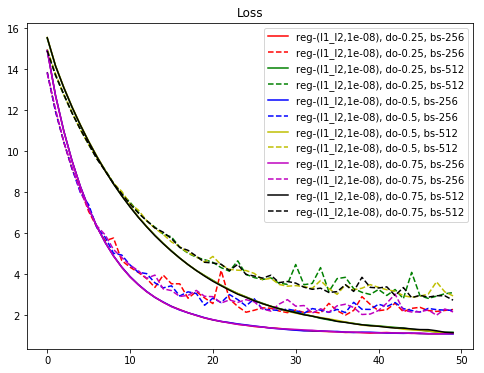

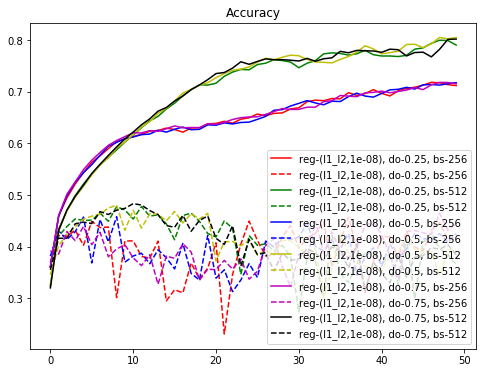

In [8]:
for reg,reg_ratio in REGULARIZATION.items():
    results = {}
    for do in Dropout_EXP:
        for bs in BATCH_SIZE:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print('----------------------------------------------------')
            print("Experiment with regularizers = (%s,%s), dropout = %.3f, batch_size=%d" % (reg, str(reg_ratio), do, bs))
            model = build_mlp(input_shape=x_train.shape[1:], reg=reg, reg_ratio=reg_ratio, drp_ratio=do)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=bs, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "reg-(%s,%s), do-%s, bs-%d" % (reg, str(reg_ratio), str(do), bs)
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}
    showPicture(results) # 每個 regularization 一張圖